
Title: XGBoost Regressor for Property Prediction
=======
- Created: 2019.11.06
- Updated: 2019.11.22
- Author: Kyung Min, Lee

Learned from 
- "Chapter 2 of Hands-on Machine Learning Book"
- xgboost documentation: https://xgboost.readthedocs.io/en/latest/index.html
- https://zzsza.github.io/data/2018/07/03/xgboost/
- paper: "XGBoost: A Scalable Tree Boosting System", - Tianqi Chen(University of Washington
- https://brunch.co.kr/@snobberys/137
- https://bcho.tistory.com/1354


## XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

> class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,
                     silent=True, objective='reg:linear', booster='gbtree',
                     n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                     max_delta_step=0, subsample=1, colsample_bytree=1,
                     colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                     scale_pos_weight=1, base_score=0.5, random_state=0,
                     seed=None, missing=None, **kwargs)

- 


### Extreme Gradient Boost
- - -
- Boosting 알고리즘 사용: greedy algorithm을 사용하여 분류기를 발견하고, 분산처리를 사용하여 빠른(Extreme) 속도로 적합한 비중 파라메터를 찾는 알고리즘이다. 분류기는 Regression Score를 사용하여 정확도를 측정하고, 각 순서에 따라 강한 분류기부터 약한 분류기까지 랜덤하게 생성된다. 이렇게 만들어진 분류기를 tree라고 하며, 분류기를 조합한 최종 알고리즘을 forest라고 한다.

- xgboost는 트리를 만들때 CART(Classification And Regression Trees)라는 앙상블 모델을 사용한다. 이후 트리 부스팅을 사용하여, 각 분류기간 weight를 최적화한다. 

- CART 모델은 일반적인 Decision Tree(leaf node 하나에 대해서만 decision value를 가짐)와는 달리 모든 leaf들이 모델의 최종 스코어에 연관되어 있다. 따라서 Decision tree가 분류를 제대로 했는지에 대해서만 초점을 맞추는 반면, CART는 같은 분류를 갖는 모델끼리도 모델의 우위를 비교할 수 있다(스코어 비교). 모든 trainig data를 forest에 넣고 결과값으로 나오는 점수의 절데값을 더한다.

  


# Algorithm

- Model: assuming we have K tres
$$ \widehat y_i  = \sum^K_{k=1} f_k(x_i), \qquad f_k \in F$$
- Objective = Training loss + Complexity of the Trees(모델의 복잡도, Bias-variance tradeoff 맞춰
$$ Obj = \sum^n_{i=1} l(y_i, \widehat y_i) + \sum^K_{k=1} \Omega(f_k) $$

  - Complexity of the Trees: 모델의 복잡도, Bias-variance tradeoff 맞춰주는 함수. CART와 분산처리로 수 없이 많은 트리가 만들어 질텐데, 그 중에서 엑기스만 뽑아 숲을 만든다
  
- The prediction at rount t is $ \widehat y^{(t)}_i = \widehat y^{(t-1)}_i + f_t(x_i) $. $f_t(x_i)$ is what we need to decide in round t.
$$ Obj = \sum^n_{i=1} l(y_i, \widehat y_i) + \sum^K_{k=1} \Omega(f_i) =  \sum^n_{i=1} l(y_i, \widehat y_i + f_t(x_i)) + \sum^K_{k=1} \Omega(f_t) + constant $$ 
  - Goal: find $f_t$ to minimize $ \sum^n_{i=1} l(y_i, \widehat y_i + f_t(x_i)) + \sum^K_{k=1} \Omega(f_t)$
  
- Consider square loss for smooth understanding
$$ Obj^{(t)} = \sum^n_{i=1} [y_i - (\widehat y_i^{(t-1)} +f_t(x_i))]^2 + \Omega (f_t) + const = \sum^n_{i=1} [2(\widehat y_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)]^2 + \Omega (f_t) + const $$
  - $ 2(\widehat y_i^{(t-1)} - y_i) $ becomes the loss of round (t-1).
  
- Turn loss of round (t-1) to Taylor Expansion. Theoretically, it converges without big diffrence from the original function and, engineerically it is well-structured to implement calculation for computer

  - Take Taylor expansion of the objective
    - Recall $f(x+\triangle x) \cong f(x) + f'(x) \triangle x + \frac{1}{2} f''(x) \triangle x^2$
    - Define $ g_i = \partial_{\widehat y^{(t-1)}} l(y_i, \widehat y^{(t-1)}), \quad h_i = \partial^2_{\widehat y^{(t-1)}} l(y_i, \widehat y^{(t-1)})$
    $$ Obj^{(t)} \cong \sum^n_{i=1}[l(y_i, \widehat y_i^{(t-1)} + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + constant$$

- Now the probelm is described with g(first-order gradient) and h(second-order gradient). Disregarding the constant form results.
$$ \sum^n_{i=1}[g_i f_t(x_i) + \frac{1}{2} h_i f^2_t(x_i)] + \Omega(f_t) $$
where  $ g_i = \partial_{\widehat y^{(t-1)}} l(y_i, \widehat y^{(t-1)}), \quad h_i = \partial^2_{\widehat y^{(t-1)}} l(y_i, \widehat y^{(t-1)})$
  - This is the re-definition of loss-function. Since g,h is derivation at (t-1), we can fine convergence form when it is expanded infinitely. *xgboost* lets users define approximation function manually and uses Linear Taylor Expansion equation at default so that divides functions into the form that can be easily executed in parallel processing
  
- $\Omega$ is adjusting the weight of tree. Xgboost defines $\Omega$ as...
$$ \Omega(f_t) = \gamma T + \frac{1}{2} \lambda \sum^T_{j=1} \omega^2_j = Number of leaves + L2 norm of leaf scores $$
  - Thus, leaf score and number of leaves($\gamma$) determines model($f_t$)'s complexity
  
- Applying all ideas into the objective function and sort them with respct to weights
  - Define the instance set in leaf j as $I_j = {i|q(x_i) = j}$
  - Regroup the objective by each leaf
  $$ Obj^{(t)} \cong \sum^n_{i=1} [g_i f_t(x_i) + \frac{1}{2} h_i f^2_t(x_i)] + \Omega(f_t)  $$
   $$= \sum^n_{i=1} [g_i f_t(x_i) + \frac{1}{2} h_i f^2_t(x_i)] + \gamma T + \lambda 1/2 sum^T_{j=1}\omega^2+j   $$ $$= \sum^T_{j=1} [(\sum_{i\in I_j}g_i)\omega_j + \frac{1}{2}(\sum_{i\in I_j}h_i+\lambda)\omega^2_j] + \gamma T$$
   - This is sum of T independent quadratic functions
   
 - Objective function can be expanded of T addition of quadratic function of the weight. Solving of x which is the mininum point with respect to g, h and the minimum point are...
 $$ argmin_x Gx + \frac{1}{2}Hx^2 = - G/H, \quad H>0, \qquad min_x /: G_x + \frac{1}{2} Hx^2 = -1/2 \frac{G^2}{H} $$
 
- Concise the function: sum of g as G & sum of h as H. Then the most optimized weight with respect to the objective function $w^*$ and the optimized value are
 $$ w^*_j = -\frac{G_j}{H_j + \lambda} \qquad Obj = -\frac{1}{2} \sum^T_{j=1} \frac{G^2_j}{H_j + \lambda} + \lambda T$$
   - We got objective function that has optimized score and weight when given T tree.
 
- We can calculate information gain as we prone the twig with the confidence for the above procedures which expand the objective function easily and get to the optimized convergence. Therefore, we just add the twig of the tree infinitely and greedy: Split Finding. We sequentially divide binary twig and calculate information gain, and prone when the score is negative value.

- L: Left side children score & R: Right side children score. Given we prone the twig at specific depth, $$information \: gain = \frac{G^2_L}{H_L + \lambda} + \frac{G^2_R}{H_R + \lambda} - \frac{(G^2_L + G_R)^2}{(H_L + H_R + \lambda)} - \gamma$$

- Now get the standard randomly, and create the tree which prones the twig until it contains maximum information gain. And iterate the procedures. Finally boosting with the combination of such trees which have high scores(positive real value)

- Thus, the result is optimized model which mixes T trees


# General parameters
---

- relate to which booster we are using to do boosting, commonly tree or linear model

- **booster** [default= gbtree ]Which booster to use.
  - Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.

- **nthread**[default to maximum number of threads available if not set]: Number of parallel threads used to run XGBoost

- **num_feature**[set automatically by XGBoost, no need to be set by user]: Feature dimension used in boosting, set to maximum dimension of the feature

- - -
- **disable_default_eval_metric**[default=0]: Flag to disable default metric. Set to >0 to disable.

- **num_pbuffer**[set automatically by XGBoost, no need to be set by user]: Size of prediction buffer, normally set to number of training instances. 
  - The buffers are used to save the prediction results of last boosting step.

- **verbosity** [default=1]: Verbosity of printing messages. 
  - Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). Sometimes XGBoost tries to change configurations based on heuristics, which is displayed as warning message. If there’s unexpected behaviour, please try to increase value of verbosity.


Booster parameters 
---
- depend on which booster you have chosen

## Additional parameters for Dart Booster (booster=dart)

- If the booster object is DART type, predict() will perform **dropouts**, i.e. only some of the trees will be evaluated. This will produce incorrect results if data is not the training data. To obtain correct results on test sets, set ntree_limit to a nonzero value,

- **sample_type** [default= uniform]: Type of sampling algorithm.
  - *uniform*: dropped trees are selected uniformly.
  - *weighted*: dropped trees are selected in proportion to weight.

- **normalize_type**[default= tree]: Type of normalization algorithm.
  - *tree*: new trees have the same weight of each of dropped trees.
    - Weight of new trees are 1 / (k + learning_rate).
    - Dropped trees are scaled by a factor of k / (k + learning_rate).
  - *forest*: new trees have the same weight of sum of dropped trees (forest).
    - Weight of new trees are 1 / (1 + learning_rate).
    - Dropped trees are scaled by a factor of 1 / (1 + learning_rate).

- **rate_drop**[default=0.0]: Dropout rate (a fraction of previous trees to drop during the dropout).
  - range: [0.0, 1.0]

- **one_drop**[default=0]: When this flag is enabled, at least one tree is always dropped during the dropout (allows Binomial-plus-one or epsilon-dropout from the original DART paper).

- **skip_drop** [default=0.0]: Probability of skipping the dropout procedure during a boosting iteration.
  - If a dropout is skipped, new trees are added in the same manner as gbtree.
  - Note that non-zero skip_drop has higher priority than rate_drop or one_drop.

  - range: [0.0, 1.0]

## Parameters for Linear Booster (booster=gblinear)

- **lambda** [default=0, alias: reg_lambda]: L2 regularization term on weights.
  - Increasing this value will make model more conservative. Normalised to number of training examples.

- **alpha**[default=0, alias: reg_alpha]: L1 regularization term on weights. 
  - Increasing this value will make model more conservative. Normalised to number of training examples.
  
  - - -

- **updater** [default= shotgun]: Choice of algorithm to fit linear model
  - *shotgun*: Parallel coordinate descent algorithm based on shotgun algorithm. Uses ‘hogwild’ parallelism and therefore produces a nondeterministic solution on each run.
  - *coord_descent*: Ordinary coordinate descent algorithm. Also multithreaded but still produces a deterministic solution.

- **feature_selector** [default= cyclic] : Feature selection and ordering method
  - *cyclic*: Deterministic selection by cycling through features one at a time.
  - *shuffle*: Similar to cyclic but with random feature shuffling prior to each update.
  - *random*: A random (with replacement) coordinate selector.
  - *greedy*: Select coordinate with the greatest gradient magnitude. It has O(num_feature^2) complexity. It is fully deterministic. It allows restricting the selection to top_k features per group with the largest magnitude of univariate weight change, by setting the top_k parameter. Doing so would reduce the complexity to O(num_feature*top_k).
  - *thrifty*: Thrifty, approximately-greedy feature selector. Prior to cyclic updates, reorders features in descending magnitude of their univariate weight changes. This operation is multithreaded and is a linear complexity approximation of the quadratic greedy selection. It allows restricting the selection to top_k features per group with the largest magnitude of univariate weight change, by setting the top_k parameter.

- **top_k** [default=0]: The number of top features to select in greedy and thrifty feature selector. The value of 0 means using all the features.

## Parameters for Tweedie Regression (objective=reg:tweedie)

- **tweedie_variance_power**[default=1.5]: 
  - Parameter that controls the variance of the Tweedie distribution 
    - var(y) ~ E(y)^tweedie_variance_power
  - range: (1,2)
  - Set closer to 2 to shift towards a gamma distribution
  - Set closer to 1 to shift towards a Poisson distribution.

## Parameters for Tree Booster

- **lambda** [default=1, alias: reg_lambda]: L2 regularization term on weights. Increasing this value will make model more conservative.

- **alpha** [default=0, alias: reg_alpha]: L1 regularization term on weights. Increasing this value will make model more conservative.

- **eta** [default=0.3, alias: learning_rate]: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
  - range: [0,1]

- **gamma** [default=0, alias: min_split_loss]: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
  - described as -r in the Information Gain
  - range: [0,∞]

- **max_depth** [default=6]: Maximum depth of a tree. 
  - Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

  - range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist)

- **min_child_weight** [default=1]: Minimum sum of instance weight (hessian) needed in a child. 
  - If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.
  - range: [0,∞]

 - - -
 
- **max_delta_step** [default=0]: Maximum delta step we allow each leaf output to be. 
  - If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
  - range: [0,∞]

- **subsample** [default=1]: Subsample ratio of the training instances. 
  - Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
  - range: (0,1]

- **colsample_bytree**, **colsample_bylevel**, **colsample_bynode** [default=1]
  - This is a family of parameters for subsampling of columns.

  - All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.

  - *colsample_bytree* is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

  - *colsample_bylevel* is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.

  - *colsample_bynode* is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.

  - *colsample_by* parameters work cumulatively. For instance, the combination {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5} with 64 features will leave 8 features to choose from at each split.


- **tree_method** string [default= auto]: 
  - The tree construction algorithm used in XGBoost. See description in the reference paper.
  - XGBoost supports hist and approx for distributed training and only support approx for external memory version.
  - Choices: auto, exact, approx, hist, gpu_hist
    - *auto*: Use heuristic to choose the fastest method.
      - For small to medium dataset, exact greedy (exact) will be used.
      - For very large dataset, approximate algorithm (approx) will be chosen.
      - Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.

    - *exact*: Exact greedy algorithm.
    - *approx*: Approximate greedy algorithm using quantile sketch and gradient histogram.
    - *hist*: Fast histogram optimized approximate greedy algorithm. It uses some performance improvements such as bins caching.
    - *gpu_hist*: GPU implementation of hist algorithm.

- **sketch_eps** [default=0.03]
  - Only used for tree_method=approx.
  - This roughly translates into O(1 / sketch_eps) number of bins. Compared to directly select number of bins, this comes with theoretical guarantee with sketch accuracy.
  - Usually user does not have to tune this. But consider setting to a lower number for more accurate enumeration of split candidates.
  - range: (0, 1)

- **scale_pos_weight** [default=1]
  - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). See Parameters Tuning for more discussion. Also, see Higgs Kaggle competition demo for examples: R, py1, py2, py3.

- **updater** [default= grow_colmaker,prune]
  - A comma separated string defining the sequence of tree updaters to run, providing a modular way to construct and to modify the trees. This is an advanced parameter that is usually set automatically, depending on some other parameters. However, it could be also set explicitly by a user. The following updaters exist:
    - *grow_colmaker*: non-distributed column-based construction of trees.
    - *distcol*: distributed tree construction with column-based data splitting mode.
    - *grow_histmaker*: distributed tree construction with row-based data splitting based on global proposal of histogram counting.
    - *grow_local_histmaker*: based on local histogram counting.
    - *grow_skmaker*: uses the approximate sketching algorithm.
    - *sync*: synchronizes trees in all distributed nodes.
    - *refresh*: refreshes tree’s statistics and/or leaf values based on the current data. Note that no random subsampling of data rows is performed.
    - *prune*: prunes the splits where loss < min_split_loss (or gamma).
  - In a distributed setting, the implicit updater sequence value would be adjusted to grow_histmaker,prune by default, and you can set tree_method as hist to use grow_histmaker.

- **refresh_leaf** [default=1]: This is a parameter of the refresh updater.
  - When this flag is 1, tree leafs as well as tree nodes’ stats are updated. When it is 0, only node stats are updated.

- **process_type** [default= default]: A type of boosting process to run.
  - Choices: default, update
    - *default*: The normal boosting process which creates new trees.
    - *update*: Starts from an existing model and only updates its trees. In each boosting iteration, a tree from the initial model is taken, a specified sequence of updaters is run for that tree, and a modified tree is added to the new model. The new model would have either the same or smaller number of trees, depending on the number of boosting iteratons performed. Currently, the following built-in updaters could be meaningfully used with this process type: refresh, prune. With process_type=update, one cannot use updaters that create new trees.

- **grow_policy** [default= depthwise]: Controls a way new nodes are added to the tree.
  - Currently supported only if tree_method is set to hist.
  - Choices: depthwise, lossguide
    - *depthwise*: split at nodes closest to the root.
    - *lossguide*: split at nodes with highest loss change.

- **max_leaves** [default=0]: Maximum number of nodes to be added. Only relevant when grow_policy=lossguide is set.

- **max_bin** [default=256]: Only used if tree_method is set to hist.
  - Maximum number of discrete bins to bucket continuous features.
  - Increasing this number improves the optimality of splits at the cost of higher computation time.

- **predictor** [default=``cpu_predictor``]The type of predictor algorithm to use. 
  - Provides the same results but allows the use of GPU or CPU.
    - *cpu_predictor*: Multicore CPU prediction algorithm.
    - *gpu_predictor*: Prediction using GPU. Default when tree_method is gpu_hist.

- **num_parallel_tree** [default=1] - Number of parallel trees constructed during each iteration. 
  - This option is used to support boosted random forest.

Learning task parameters
---
- decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

- **objective** [default=reg:squarederror]: 목적함수
  - *reg:squarederror*: regression with squared loss.
  - *reg:squaredlogerror*: regression with squared log loss $\frac{1}{2}[log(pred+1)−log(label+1)]^2$. All input labels are required to be greater than -1. Also, see metric rmsle for possible issue with this objective.
  - *reg:logistic*: logistic regression
  - *binary:logistic*: logistic regression for binary classification, output probability
  - *binary:logitraw*: logistic regression for binary classification, output score before logistic transformation
  - *binary:hinge*: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
  - *count:poisson* –poisson regression for count data, output mean of poisson distribution
    - *max_delta_step* is set to 0.7 by default in poisson regression (used to safeguard optimization)
  - *survival:cox*: Cox regression for right censored survival time data (negative values are considered right censored). Note that predictions are returned on the hazard ratio scale (i.e., as HR = exp(marginal_prediction) in the proportional hazard function h(t) = h0(t) * HR).
  - *multi:softmax*: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
  - *multi:softprob*: same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.
  - *rank:pairwise*: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized
  - *rank:ndcg*: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized
  - *rank:map*: Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized
  - *reg:gamma*: gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.
  - *reg:tweedie*: Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.
  
- **eval_metric** [default according to objective]: 데이터의 특성에 맞게 평가함수 조정
  - Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and error for classification, mean average precision for ranking)
  - User can add multiple evaluation metrics. Python users: remember to pass the metrics in as list of parameters pairs instead of map, so that latter eval_metric won’t override previous one
  - The choices are listed below:
    - *rmse*: root mean square error
    - *rmsle*: root mean square log error: $\sqrt \frac{1}{N}[log(pred+1)−log(label+1)]^2$. Default metric of *reg:squaredlogerror* objective. This metric reduces errors generated by outliers in dataset. But because log function is employed, *rmsle* might output nan when prediction value is less than -1. See *reg:squaredlogerror* for other requirements.
    - *mae*: mean absolute error
    - *logloss*: negative log-likelihood
    - *error*: Binary classification error rate. It is calculated as $\frac{\#(wrong cases)}{\#(all cases)}$. For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
    - *error@t*: a different than 0.5 binary classification threshold value could be specified by providing a numerical value through ‘t’.
    - *merror*: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).
    - *mlogloss*: Multiclass logloss.
    - *auc*: Area under the curve
    - *aucpr*: Area under the PR curve
    - *ndcg*: Normalized Discounted Cumulative Gain
    - *map*: Mean Average Precision
    - *ndcg@n*, *map@n*: ‘n’ can be assigned as an integer to cut off the top positions in the lists for evaluation.
    - *ndcg-*, *map-*, *ndcg@n-*, *map@n-*: In XGBoost, NDCG and MAP will evaluate the score of a list without any positive samples as 1. By adding “-” in the evaluation metric XGBoost will evaluate these score as 0 to be consistent under some conditions.
    - *poisson-nloglik*: negative log-likelihood for Poisson regression
    - *gamma-nloglik*: negative log-likelihood for gamma regression
    - *cox-nloglik*: negative partial log-likelihood for Cox proportional hazards regression
    - *gamma-deviance*: residual deviance for gamma regression
    - *tweedie-nloglik*: negative log-likelihood for Tweedie regression (at a specified value of the *tweedie_variance_power* parameter)

- **seed** [default=0]: Random number seed.
 - - - 
  
- **base_score** [default=0.5]
  - The initial prediction score of all instances, global bias
  - For sufficient number of iterations, changing this value will not have too much effect.



Command line parameters 
---
- relate to behavior of CLI version of XGBoost.

- **num_round**: boosting round 결정, 랜덤하게 생성되는 모델이므로 이 수가 적당히 커야한다. epoch

- - -
- **data**: The path of training data

- **test:data**: The path of test data to do prediction

- **save_period** [default=0]The period to save the model. 
  - Setting save_period=10 means that for every 10 rounds XGBoost will save the model. Setting it to 0 means not saving any model during the training.
  
- **task** [default= train] options: *train*, *pred*, *eval*, *dump*
  - *train*: training using data
  - *pred*: making prediction for test:data
  - *eval*: for evaluating statistics specified by eval[name]=filename
  - *dump*: for dump the learned model into text format

- **model_in** [default=NULL]: Path to input model, needed for test, eval, dump tasks. If it is specified in training, XGBoost will continue training from the input model.

- **model_out** [default=NULL]: Path to output model after training finishes. 
  - If not specified, XGBoost will output files with such names as 0003.model where 0003 is number of boosting rounds.

- **model_dir** [default= models/]: The output directory of the saved models during training

- **fmap**: Feature map, used for dumping model

- **dump_format** [default= text] options: *text*, *json*: Format of model dump file

- **name_dump** [default= dump.txt]: Name of model dump file

- **name_pred** [default= pred.txt]: Name of prediction file, used in pred mode

- **pred_margin** [default=0]: Predict margin instead of transformed probability

# Scikit API for XGBRegressor

- Bases: xgboost.sklearn.XGBModel, object

## Parameters
- **max_depth** (int) – Maximum tree depth for base learners.

- **learning_rate** (float) – Boosting learning rate (xgb’s “eta”)

- **n_estimators** (int) – Number of trees to fit.

- **objective** (string or callable) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).

- **booster** (string) – Specify which booster to use: gbtree, gblinear or dart.

- **n_jobs** (int) – Number of parallel threads used to run xgboost.

- **gamma** (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.

- **reg_alpha** (float (xgb's alpha)) – L1 regularization term on weights

- **reg_lambda** (float (xgb's lambda)) – L2 regularization term on weights

- - -
- **verbosity** (int) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).

- **tree_method** (string) – Specify which tree method to use. Default to auto. If this parameter is set to default, XGBoost will choose the most conservative option available. It’s recommended to study this option from parameters document.

- **min_child_weight** (int) – Minimum sum of instance weight(hessian) needed in a child.

- **max_delta_step** (int) – Maximum delta step we allow each tree’s weight estimation to be.

- **subsample** (float) – Subsample ratio of the training instance.

- **colsample_bytree** (float) – Subsample ratio of columns when constructing each tree.

- **colsample_bylevel** (float) – Subsample ratio of columns for each level.

- **colsample_bynode** (float) – Subsample ratio of columns for each split.

- **scale_pos_weight** (float) – Balancing of positive and negative weights.

- **base_score** – The initial prediction score of all instances, global bias.

- **random_state** (int) – Random number seed.

  - Note: Using gblinear booster with shotgun updater is nondeterministic as it uses Hogwild algorithm.

- **missing** (float, optional) – Value in the data which needs to be present as a missing value. If None, defaults to np.nan.

- **num_parallel_tree** (int) – Used for boosting random forest.

- **importance_type** (string, default "gain") – The feature importance type for the feature_importances_ property: either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.

- **\*\*kwargs** (dict, optional) – unsupported by scikit-learn


# Parameter Tuning
- - - 
## Control Overfitting
- There are in general two ways that you can control overfitting in XGBoost:
  - The first way is to directly control model complexity.
    - This includes max_depth, min_child_weight and gamma.
  - The second way is to add randomness to make training robust to noise.
    - This includes subsample and colsample_bytree.
    - You can also reduce stepsize eta. Remember to increase num_round when you do so.
    
## Handle Imbalanced Dataset
- For common cases such as ads clickthrough log, the dataset is extremely imbalanced. This can affect the training of XGBoost model, and there are two ways to improve it.
  - If you care only about the overall performance metric (AUC) of your prediction
    - Balance the positive and negative weights via scale_pos_weight
    - Use AUC for evaluation
  - If you care about predicting the right probability
    - In such a case, you cannot re-balance the dataset
    - set parameter max_delta_step to a finite number (say 1) to help convergence
 

Attributes
---

- **feature_importances_**[array, shape (n_features,)]: Return the feature importances (the higher, the more important the feature).
  - defined only fore tree boosters or decision tree is choosed as base learner

- **evals_result()**[dict]: Return the evaluation results.
  - If eval_set is passed to the fit function, you can call evals_result() to get evaluation results for all passed eval_sets. When eval_metric is also passed to the fit function, the evals_result will contain the eval_metrics passed to the fit function.

- **coef_**[array, shape (n_features) or (n_classes, n_features)]: Coefficients property
  - Coefficients are defined only for linear learners. Coefficients are only defined when the linear model is chosen as base learner (booster=gblinear).



Method
---


- **apply(X,ntree_limit=0)**[array, shape=[n_samples, n_trees]: Return the predicted leaf every tree for each sample
  - Parameters
    - X (array_like, shape=[n_samples, n_features]) – Input features matrix.
    - ntree_limit (int) – Limit number of trees in the prediction; defaults to 0 (use all trees).
  - Returns
    - X_leaves – For each datapoint x in X and for each tree, return the index of the leaf x ends up in. Leaves are numbered within [0; 2**(self.max_depth+1)), possibly with gaps in the numbering.

- **fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None)**:Fit the gradient boosting model.
  - Parameters
    - X (array_like) – Feature matrix
    - y (array_like) – Labels
    - sample_weight (array_like) – instance weights
    - eval_set (list, optional) – A list of (X, y) tuple pairs to use as validation sets, for which metrics will be computed. Validation metrics will help us track the performance of the model.
    - sample_weight_eval_set (list, optional) – A list of the form [L_1, L_2, …, L_n], where each L_i is a list of instance weights on the i-th validation set.
    - eval_metric (str, list of str, or callable, optional) – If a str, should be a built-in evaluation metric to use. See doc/parameter.rst. If a list of str, should be the list of multiple built-in evaluation metrics to use. If callable, a custom evaluation metric. The call signature is func(y_predicted, y_true) where y_true will be a DMatrix object such that you may need to call the get_label method. It must return a str, value pair where the str is a name for the evaluation and value is the value of the evaluation function. The callable custom objective is always minimized.
    - early_stopping_rounds (int) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in eval_set. The method returns the model from the last iteration (not the best one). If there’s more than one item in eval_set, the last entry will be used for early stopping. If there’s more than one metric in eval_metric, the last metric will be used for early stopping. If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.
    - verbose (bool) – If verbose and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.
    - xgb_model (str) – file name of stored XGBoost model or ‘Booster’ instance XGBoost model to be loaded before training (allows training continuation).
    - callbacks (list of callback functions) – List of callback functions that are applied at end of each iteration. It is possible to use predefined callbacks by using Callback API. 
      - Example:[xgb.callback.reset_learning_rate(custom_rates)]
      
- **get_booster()**: Get the underlying xgboost Booster of this model.This will raise an exception when fit was not called
  - Returns: booster(type: a xgboost booster of underlying model)
  
- **get_num_boosting_rounds()** : Gets the number of xgboost boosting rounds.
- **get_params**(deep=False): Get Parameters
- **get_xgb_params()**: Get xgboost type parameters.
- property **intercept_**: Intercept (bias) property
  - Intercept is defined only for linear learners. Intercept (bias) is only defined when the linear model is chosen as base learner (booster=gblinear). It is not defined for other base learner types, such as tree learners (booster=gbtree).
  - Returns: intercept_(type: array of shape (1,) or [n_classes])
  
- **load_model**(filename): Load the model from a file.
  - The model is loaded from an XGBoost internal binary format which is universal among the various XGBoost interfaces. Auxiliary attributes of the Python Booster object (such as feature names) will not be loaded. Label encodings (text labels to numeric labels) will be also lost. If you are using only the Python interface, we recommend pickling the model object for best results.
  - Parameters: fname (string or a memory buffer) – Input file name or memory buffer(see also save_raw)

- **predict**(data, output_margin=False, ntree_limit=None, validate_features=True): Predict with data.
  - This function is not thread safe. For each booster object, predict can only be called from one thread. If you want to run prediction using multiple thread, call xgb.copy() to make copies of model object and then call predict().
  - Parameters 
    - data (numpy.array/scipy.sparse) – Data to predict with
    - output_margin (bool) – Whether to output the raw untransformed margin value.
    - ntree_limit (int) – Limit number of trees in the prediction; defaults to best_ntree_limit if defined (i.e. it has been trained with early stopping), otherwise 0 (use all trees).
    - validate_features (bool) – When this is True, validate that the Booster’s and data’s feature_names are identical. Otherwise, it is assumed that the feature_names are the same.
  - Returns: prediction(type: np.array)
  
- **save_model**(fname): Save the model to a file.
  - The model is saved in an XGBoost internal binary format which is universal among the various XGBoost interfaces. Auxiliary attributes of the Python Booster object (such as feature names) will not be loaded. Label encodings (text labels to numeric labels) will be also lost. If you are using only the Python interface, we recommend pickling the model object for best results.
  - Parameters: fname (string) – Output file name
  
- **set_params**(\*\*params)
  - Set the parameters of this estimator. Modification of the sklearn method to allow unknown kwargs. This allows using the full range of xgboost parameters that are not defined as member variables in sklearn grid search. :returns: :rtype: self
  

  
  
  
  

Setup
---

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

# import xgboost
import xgboost as xgb

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
sklearn.__version__

'0.21.1'

Get the data
============

In [240]:
from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():
  print('User uploaded file"{name}" with length{length} bytes'.format(
      name = fn, length=len(uploaded[fn])
  ))

ModuleNotFoundError: No module named 'google.colab'

In [241]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import pandas as pd

df = pd.read_csv("data.csv")
df.head()


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,1800,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,1600,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,800,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,1000,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,500,0.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 12 columns):
layer_height          118 non-null float64
wall_thickness        118 non-null int64
infill_density        118 non-null int64
infill_pattern        118 non-null object
nozzle_temperature    118 non-null int64
bed_temperature       118 non-null int64
print_speed           118 non-null int64
material              118 non-null object
fan_speed             118 non-null int64
roughness             118 non-null int64
tension_strength      118 non-null int64
elongation            118 non-null float64
dtypes: float64(2), int64(8), object(2)
memory usage: 11.1+ KB


4 Variable (layer_height & wall_thickness & infill_density & nozzle temperature) data
---

In [6]:
df = df.loc[:,["layer_height","wall_thickness","nozzle_temperature", "tension_strength", "elongation"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
layer_height          118 non-null float64
wall_thickness        118 non-null int64
nozzle_temperature    118 non-null int64
tension_strength      118 non-null int64
elongation            118 non-null float64
dtypes: float64(2), int64(3)
memory usage: 4.7 KB


In [17]:
df = df.loc[:,["layer_height","wall_thickness","infill_density","nozzle_temperature", "tension_strength", "elongation"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
layer_height          118 non-null float64
wall_thickness        118 non-null int64
infill_density        0 non-null float64
nozzle_temperature    118 non-null int64
tension_strength      118 non-null int64
elongation            118 non-null float64
dtypes: float64(3), int64(3)
memory usage: 5.6 KB


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
df.describe()

,layer_height,wall_thickness,nozzle_temperature,tension_strength,elongation
count,118.000000,118.000000,118.000000,118.000000,118.000000
mean,0.102458,5.313559,221.822034,2006.779661,1.658475
std,0.062278,2.925570,14.641955,879.853214,0.759591
min,0.020000,1.000000,200.000000,400.000000,0.400000
25%,0.060000,3.000000,210.000000,1200.000000,1.100000
50%,0.100000,5.000000,220.000000,1900.000000,1.500000
75%,0.150000,7.750000,230.000000,2700.000000,2.175000
max,0.200000,10.000000,250.000000,3700.000000,3.300000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD21967D30>,
      dtype=object)

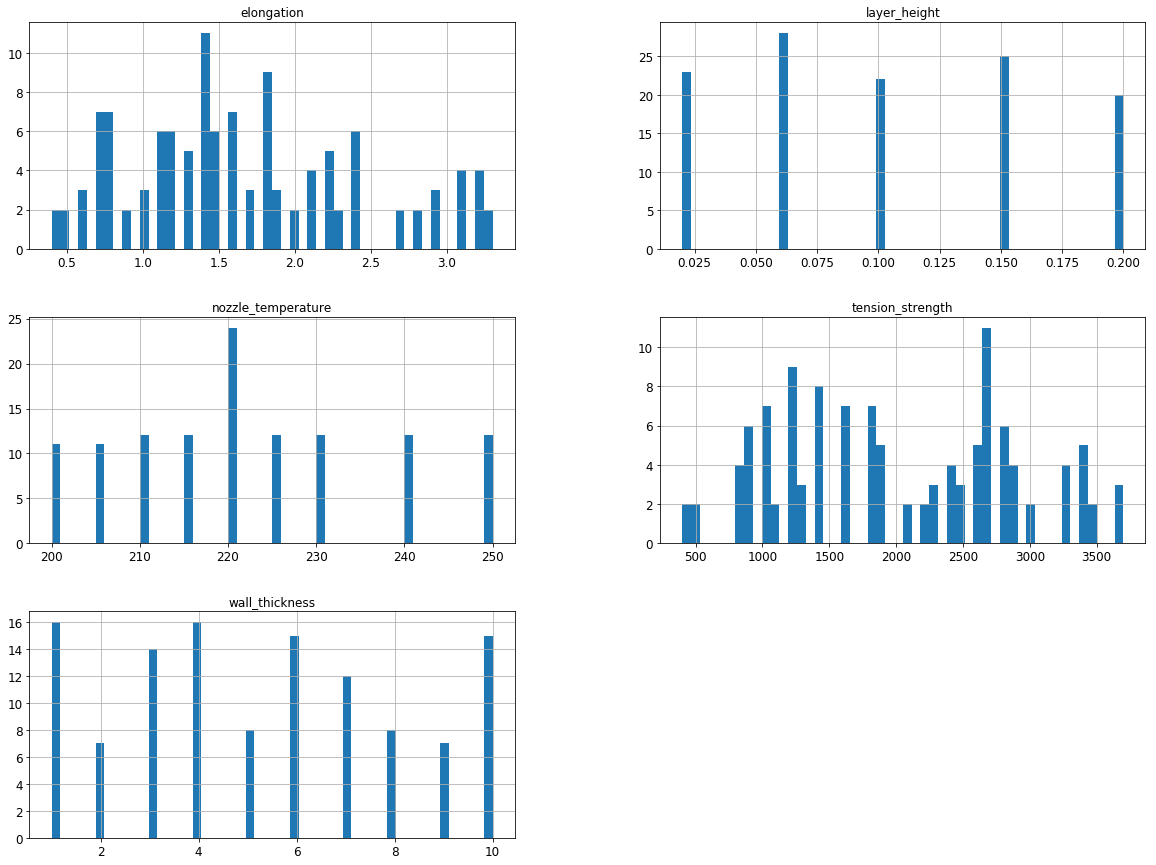

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))

In [9]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [10]:
# train, test data split
from sklearn.model_selection import train_test_split

X = df.loc[:,["layer_height", "wall_thickness","nozzle_temperature"]]
ts = df.loc[:, "tension_strength"]
elong = df.loc[:,"elongation"]

X_train, X_test, ts_train, ts_test = train_test_split(X, ts, test_size=0.3, random_state=42)
X_train, X_test, el_train, el_test = train_test_split(X, elong, test_size=0.3, random_state=42)
len(X_train)

82

In [20]:
len(X_test)

36

Discover and visualize the data to gain insights
===

In [21]:
# Copy the dataset in order not to harm train set
df_copy = df.copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
layer_height          118 non-null float64
wall_thickness        118 non-null int64
nozzle_temperature    118 non-null int64
tension_strength      118 non-null int64
elongation            118 non-null float64
dtypes: float64(2), int64(3)
memory usage: 4.7 KB


In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 62 to 102
Data columns (total 3 columns):
layer_height          82 non-null float64
wall_thickness        82 non-null int64
nozzle_temperature    82 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.6 KB


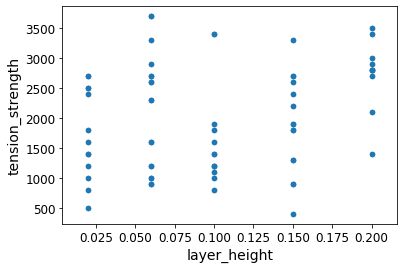

In [252]:
df_copy.plot(kind="scatter", x="layer_height", y="tension_strength")

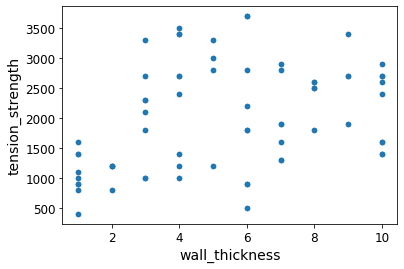

In [253]:
df_copy.plot(kind="scatter", x="wall_thickness", y="tension_strength")

In [254]:
# Analysis of Standard correlation coefficient
corr_matrix = df_copy.corr()
corr_matrix

,layer_height,wall_thickness,infill_density,nozzle_temperature,tension_strength,elongation
layer_height,1.000000,-0.224745,0.026929,0.037695,0.279211,0.455312
wall_thickness,-0.224745,1.000000,0.096443,-0.141149,0.378691,0.160139
infill_density,0.026929,0.096443,1.000000,0.187668,0.386783,0.185950
nozzle_temperature,0.037695,-0.141149,0.187668,1.000000,-0.438509,-0.547601
tension_strength,0.279211,0.378691,0.386783,-0.438509,1.000000,0.838719
elongation,0.455312,0.160139,0.185950,-0.547601,0.838719,1.000000


In [255]:
# Check what affects the most for the yield stress
corr_matrix["tension_strength"].sort_values(ascending=False)


# 1kHz_voltage > 1k_RE > 1k_IM


tension_strength      1.000000
elongation            0.838719
infill_density        0.386783
wall_thickness        0.378691
layer_height          0.279211
nozzle_temperature   -0.438509
Name: tension_strength, dtype: float64

In [256]:
corr_matrix["elongation"].sort_values(ascending=False)

elongation            1.000000
tension_strength      0.838719
layer_height          0.455312
infill_density        0.185950
wall_thickness        0.160139
nozzle_temperature   -0.547601
Name: elongation, dtype: float64

## Feature Scaling

In [11]:
# Feature Scaling => Standardization
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

data_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
imputer = SimpleImputer(strategy="median")

X_train = imputer.fit_transform(X_train)
X_train_std = data_pipeline.fit_transform(X_train)

ts_train = np.array(ts_train)
ts_train = ts_train.reshape(-1, 1)
ts_train = imputer.fit_transform(ts_train)
ts_train_std = data_pipeline.fit_transform(ts_train)

el_train = np.array(el_train)
el_train =el_train.reshape(-1, 1)
el_train = imputer.fit_transform(el_train)
el_train_std = data_pipeline.fit_transform(el_train)

X_test = imputer.fit_transform(X_test)
X_test_std =data_pipeline.fit_transform(X_test)

ts_test = np.array(ts_test)
ts_test = ts_test.reshape(-1, 1)
ts_test = imputer.fit_transform(ts_test)
ts_test_std = data_pipeline.fit_transform(ts_test)

el_test = np.array(el_test)
el_test = el_test.reshape(-1, 1)
el_test = imputer.fit_transform(el_test)
el_test_std = data_pipeline.fit_transform(el_test)


#print(X_train_std)

ts_test_std


array([[-0.94414257],
       [-1.85967475],
       [-1.74523323],
       [ 0.8869218 ],
       [-0.94414257],
       [ 0.31471419],
       [ 1.00136333],
       [ 1.91689551],
       [ 1.68801247],
       [-0.1430519 ],
       [ 1.45912942],
       [-0.94414257],
       [-0.94414257],
       [-0.71525952],
       [ 0.8869218 ],
       [-0.1430519 ],
       [ 0.20027267],
       [-0.25749343],
       [ 1.11580485],
       [ 0.54359723],
       [-1.17302561],
       [ 1.68801247],
       [ 0.8869218 ],
       [-1.17302561],
       [ 0.08583114],
       [-0.48637647],
       [ 0.77248028],
       [-0.48637647],
       [-0.71525952],
       [-1.40190866],
       [ 0.31471419],
       [-1.17302561],
       [ 0.42915571],
       [ 0.42915571],
       [-0.1430519 ],
       [ 0.77248028]])

In [258]:
X_train_std.shape

(82, 4)

In [259]:
ts_train.shape

(82, 1)

Select and train a extreme gradient boosting regression model
===

> class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, objective='reg:squarederror', booster='gbtree', tree_method='auto', n_jobs=1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, missing=None, num_parallel_tree=1, importance_type='gain', **kwargs)

In [12]:
# XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train_std, ts_train_std)
ts_predictions_xgb= xgb_reg.predict(X_train_std) * np.std(ts_train) + np.mean(ts_train)
xgb_mse = mean_squared_error(ts_train, ts_predictions_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse


[15:25:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


172.91732385277317

Hyper Parameters Tuning: GridSearch CV function
---

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [261]:
range_1 = [-10, -5, -1, 1, 5, 10]
for i in range(len(range_1)):
    range_1[i] = 10 ** range_1[i]
    
print(range_1)

[1e-10, 1e-05, 0.1, 10, 100000, 10000000000]


In [262]:
range_2 = [-10, -7,-5, -3, -1, 0]
for i in range(len(range_2)):
    range_2[i] = 10 ** range_2[i]
    
print(range_2)

[1e-10, 1e-07, 1e-05, 0.001, 0.1, 1]


In [263]:
range_3 = [0, 1, 3, 5]
for i in range(len(range_3)):
    range_3[i] = 10 ** range_3[i]
    
print(range_3)

[1, 10, 1000, 100000]


In [25]:
range_1 =  [1e-15,1e-13, 1e-11]

In [26]:
range_2 =  [1e-15,1e-13, 1e-11]

In [27]:
range_3 = [6,7,8]

In [28]:
range_4 = [0.3, 0.5, 0.7, 1]

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [
# tree-base model    
 {'booster': ['gbtree'], 'lambda': range_1, 'eta': range_2, 'gamma': range_1 , 
  'min_child_weight': range_1, 'alpha': range_1, 'max_depth': range_3, 'objective': ['reg:squarederror'],
 },
  
    
]
    
xgb_reg = xgb.XGBRegressor()

grid_search = GridSearchCV(xgb_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_std, ts_train_std)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,...
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [1e-15, 1e-13, 1e-11], 'booster': ['gbtree'],
                          'eta': [1e-15, 1e-13, 1e-11],
                          'gamma': [1e-15, 1e-13, 1e-11],
                          'lambda': [1e-15, 1e-13, 1e-11],
                          'max_depth': [6, 7, 8],
                     

In [30]:
grid_search.best_params_

{'alpha': 1e-15,
 'booster': 'gbtree',
 'eta': 1e-15,
 'gamma': 1e-15,
 'lambda': 1e-15,
 'max_depth': 7,
 'min_child_weight': 1e-15,
 'objective': 'reg:squarederror'}

In [31]:
grid_search.best_estimator_

XGBRegressor(alpha=1e-15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=1e-15, gamma=1e-15,
             importance_type='gain', lambda=1e-15, learning_rate=0.1,
             max_delta_step=0, max_depth=7, min_child_weight=1e-15,
             missing=None, n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [32]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.723207921612296 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15, 'max_depth': 6, 'min_child_weight': 1e-15, 'objective': 'reg:squarederror'}
0.723207921612296 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15, 'max_depth': 6, 'min_child_weight': 1e-13, 'objective': 'reg:squarederror'}
0.723207921612296 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15, 'max_depth': 6, 'min_child_weight': 1e-11, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15, 'max_depth': 7, 'min_child_weight': 1e-15, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15, 'max_depth': 7, 'min_child_weight': 1e-13, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-15, 'booster': 'gbtree', 'eta': 1e-15, 'gamma': 1e-15, 'lambda': 1e-15,

0.723207921612296 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13, 'max_depth': 6, 'min_child_weight': 1e-13, 'objective': 'reg:squarederror'}
0.723207921612296 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13, 'max_depth': 6, 'min_child_weight': 1e-11, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13, 'max_depth': 7, 'min_child_weight': 1e-15, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13, 'max_depth': 7, 'min_child_weight': 1e-13, 'objective': 'reg:squarederror'}
0.7078875852783633 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13, 'max_depth': 7, 'min_child_weight': 1e-11, 'objective': 'reg:squarederror'}
0.7171411017018149 {'alpha': 1e-11, 'booster': 'gbtree', 'eta': 1e-13, 'gamma': 1e-11, 'lambda': 1e-13

In [33]:
ts_xgb_final_model =  grid_search.best_estimator_

In [34]:
ts_xgb_train_predictions = ts_xgb_final_model.predict(X_train_std) * np.std(ts_train) + np.mean(ts_train)
ts_xgb_train_mse = mean_squared_error(ts_train, ts_xgb_train_predictions)
ts_xgb_train_rmse = np.sqrt(ts_xgb_train_mse)
ts_xgb_train_rmse

66.13248677659668

In [35]:
ts_train_sum = np.zeros(1)

for i in range(1, len(ts_train)):
    ts_train_sum +=  ts_train[i]
    
ts_train_avg = ts_train_sum / len(ts_train)
ts_xgb_train_err = ts_xgb_train_rmse / ts_train_avg * 100
print("ts_xgb_train_err: ", ts_xgb_train_err, '%')

ts_xgb_train_err:  [3.34125934] %


In [36]:
ts_xgb_test_predictions = ts_xgb_final_model.predict(X_test_std) * np.std(ts_test) + np.mean(ts_test)
ts_xgb_test_mse = mean_squared_error(ts_test,ts_xgb_test_predictions)
ts_xgb_test_rmse = np.sqrt(ts_xgb_test_mse)
ts_xgb_test_rmse

299.26220601390725

In [37]:
ts_test_sum = np.zeros(1)

for i in range(1, len(ts_test)):
    ts_test_sum +=  ts_test[i]
    
ts_test_avg = ts_test_sum / len(ts_test)
ts_xgb_test_err = ts_xgb_test_rmse / ts_test_avg * 100
print("ts_xgb_test_err: ", ts_xgb_test_err, '%')

ts_xgb_test_err:  [15.02571746] %


### Feature importances

In [407]:
feature_importances = ts_xgb_final_model.feature_importances_
feature_importances.shape

(4,)

In [408]:
print("Feature importances")
print("layer_height", feature_importances[0])
print("infill_density", feature_importances[1])
print("wall-_thickness", feature_importances[2])
print("nozzle_temperature", feature_importances[3])


Feature importances
layer_height 0.16914637
infill_density 0.23110959
wall-_thickness 0.2479369
nozzle_temperature 0.35180718


## Central Limit Theorem

In [302]:
print(cvres['mean_train_score'].shape)
print('Combinations')

(729,)
Combinations


In [303]:
mean_train_score = cvres['mean_train_score']
print(mean_train_score)

[-0.1496858  -0.1496858  -0.1496858  -0.03018177 -0.03018177 -0.03018177
 -0.00303934 -0.00303934 -0.00303934 -0.1496858  -0.1496858  -0.1496858
 -0.03018177 -0.03018177 -0.03018177 -0.00303934 -0.00303934 -0.00303934
 -0.1496858  -0.1496858  -0.1496858  -0.03018177 -0.03018177 -0.03018177
 -0.00303934 -0.00303934 -0.00303934 -0.1496858  -0.1496858  -0.1496858
 -0.03018177 -0.03018177 -0.03018177 -0.00303934 -0.00303934 -0.00303934
 -0.1496858  -0.1496858  -0.1496858  -0.03018177 -0.03018177 -0.03018177
 -0.00303934 -0.00303934 -0.00303934 -0.1496858  -0.1496858  -0.1496858
 -0.03018177 -0.03018177 -0.03018177 -0.00303934 -0.00303934 -0.00303934
 -0.1496858  -0.1496858  -0.1496858  -0.03018177 -0.03018177 -0.03018177
 -0.00303934 -0.00303934 -0.00303934 -0.1496858  -0.1496858  -0.1496858
 -0.03018177 -0.03018177 -0.03018177 -0.00303934 -0.00303934 -0.00303934
 -0.1496858  -0.1496858  -0.1496858  -0.03018177 -0.03018177 -0.03018177
 -0.00303934 -0.00303934 -0.00303934 -0.1496858  -0.149

In [304]:
mean_test_score = cvres['mean_test_score']
print(mean_test_score)

[-0.28151505 -0.28151505 -0.28151505 -0.21263254 -0.21263254 -0.21263254
 -0.25541192 -0.25541192 -0.25541192 -0.28151505 -0.28151505 -0.28151505
 -0.21263254 -0.21263254 -0.21263254 -0.25541192 -0.25541192 -0.25541192
 -0.28151505 -0.28151505 -0.28151505 -0.21263254 -0.21263254 -0.21263254
 -0.25541192 -0.25541192 -0.25541192 -0.28151505 -0.28151505 -0.28151505
 -0.21263254 -0.21263254 -0.21263254 -0.25541192 -0.25541192 -0.25541192
 -0.28151505 -0.28151505 -0.28151505 -0.21263254 -0.21263254 -0.21263254
 -0.25541192 -0.25541192 -0.25541192 -0.28151505 -0.28151505 -0.28151505
 -0.21263254 -0.21263254 -0.21263254 -0.25541192 -0.25541192 -0.25541192
 -0.28151505 -0.28151505 -0.28151505 -0.21263254 -0.21263254 -0.21263254
 -0.25541192 -0.25541192 -0.25541192 -0.28151505 -0.28151505 -0.28151505
 -0.21263254 -0.21263254 -0.21263254 -0.25541192 -0.25541192 -0.25541192
 -0.28151505 -0.28151505 -0.28151505 -0.21263254 -0.21263254 -0.21263254
 -0.25541192 -0.25541192 -0.25541192 -0.28151505 -0

In [305]:
std_train_score = cvres['std_train_score']
print(std_train_score)

[0.02786356 0.02786356 0.02786356 0.01512416 0.01512416 0.01512416
 0.00084282 0.00084282 0.00084282 0.02786356 0.02786356 0.02786356
 0.01512416 0.01512416 0.01512416 0.00084282 0.00084282 0.00084282
 0.02786356 0.02786356 0.02786356 0.01512416 0.01512416 0.01512416
 0.00084282 0.00084282 0.00084282 0.02786356 0.02786356 0.02786356
 0.01512416 0.01512416 0.01512416 0.00084282 0.00084282 0.00084282
 0.02786356 0.02786356 0.02786356 0.01512416 0.01512416 0.01512416
 0.00084282 0.00084282 0.00084282 0.02786356 0.02786356 0.02786356
 0.01512416 0.01512416 0.01512416 0.00084282 0.00084282 0.00084282
 0.02786356 0.02786356 0.02786356 0.01512416 0.01512416 0.01512416
 0.00084282 0.00084282 0.00084282 0.02786356 0.02786356 0.02786356
 0.01512416 0.01512416 0.01512416 0.00084282 0.00084282 0.00084282
 0.02786356 0.02786356 0.02786356 0.01512416 0.01512416 0.01512416
 0.00084282 0.00084282 0.00084282 0.02786356 0.02786356 0.02786356
 0.01512416 0.01512416 0.01512416 0.00084282 0.00084282 0.0008

In [306]:
std_test_score = cvres['std_test_score']
print(std_test_score)

[0.00469437 0.00469437 0.00469437 0.06294379 0.06294379 0.06294379
 0.08698775 0.08698775 0.08698775 0.00469437 0.00469437 0.00469437
 0.06294379 0.06294379 0.06294379 0.08698775 0.08698775 0.08698775
 0.00469437 0.00469437 0.00469437 0.06294379 0.06294379 0.06294379
 0.08698775 0.08698775 0.08698775 0.00469437 0.00469437 0.00469437
 0.06294379 0.06294379 0.06294379 0.08698775 0.08698775 0.08698775
 0.00469437 0.00469437 0.00469437 0.06294379 0.06294379 0.06294379
 0.08698775 0.08698775 0.08698775 0.00469437 0.00469437 0.00469437
 0.06294379 0.06294379 0.06294379 0.08698775 0.08698775 0.08698775
 0.00469437 0.00469437 0.00469437 0.06294379 0.06294379 0.06294379
 0.08698775 0.08698775 0.08698775 0.00469437 0.00469437 0.00469437
 0.06294379 0.06294379 0.06294379 0.08698775 0.08698775 0.08698775
 0.00469437 0.00469437 0.00469437 0.06294379 0.06294379 0.06294379
 0.08698775 0.08698775 0.08698775 0.00469437 0.00469437 0.00469437
 0.06294379 0.06294379 0.06294379 0.08698775 0.08698775 0.0869

In [307]:
!ls /content/gdrive/My\ Drive/validation

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [308]:
with open('/content/gdrive/My Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt', 'w') as f:
  for key in cvres.keys():
    f.write("\n")
    f.write(key)
    f.write(": ")
    f.write(np.str(cvres[key]))
    f.write("\n")


!cat /content/gdrive/My\ Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt'

Train data plotting
---

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "BestHyperParameter/XGD_Regression/"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

Saving figure TrainPrediction_with_XGB_ParamFitted


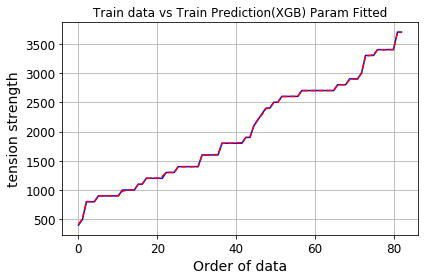

In [311]:
# Difference of train data
xx = np.linspace(0,len(X_train),len(X_train))
plt.figure
plt.grid()
ts_train_sort = np.sort(ts_train, axis=None)
ts_xgb_train_predictions_sort= np.sort(ts_xgb_train_predictions, axis=None)
plt.plot(xx,ts_train_sort,"b-", xx, ts_xgb_train_predictions_sort,"r--")
plt.title("Train data vs Train Prediction(XGB) Param Fitted")
plt.xlabel("Order of data")
plt.ylabel("tension strength")
save_fig("TrainPrediction_with_XGB_ParamFitted")

Saving figure Difference_between_Train_data_vs_Prediction_XGB_ParamFitted


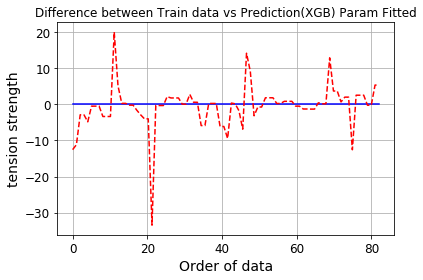

In [312]:
# Difference of train data
difference = ts_train_sort - ts_xgb_train_predictions_sort

xx = np.linspace(0,len(difference),len(difference))
y = np.zeros((len(difference),1))
#y.reshape(1,len(difference))
plt.figure
plt.grid()
plt.plot(xx,y,"b-", xx, difference,"r--")
plt.title("Difference between Train data vs Prediction(XGB) Param Fitted")
#plt.ylim(-30, 30)
plt.xlabel("Order of data")
plt.ylabel("tension strength")

save_fig("Difference_between_Train_data_vs_Prediction_XGB_ParamFitted")


Test data plotting
---

Saving figure TestPrediction_with_XGB_ParamFitted


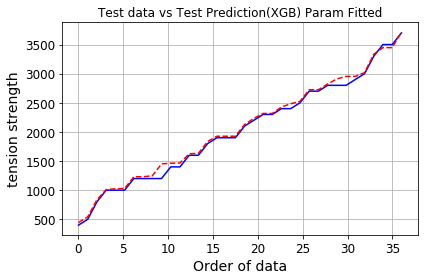

In [313]:
# Difference of train data
xx = np.linspace(0,len(X_test),len(X_test))
plt.figure
plt.grid()
ts_test_sort = np.sort(ts_test, axis=None)
ts_xgb_test_predictions_sort= np.sort(ts_xgb_test_predictions, axis=None)
plt.plot(xx,ts_test_sort,"b-", xx, ts_xgb_test_predictions_sort,"r--")
plt.title("Test data vs Test Prediction(XGB) Param Fitted")
plt.xlabel("Order of data")
plt.ylabel("tension strength")
save_fig("TestPrediction_with_XGB_ParamFitted")

Saving figure Difference_between_Test_data_vs_Prediction_XGB_ParamFitted


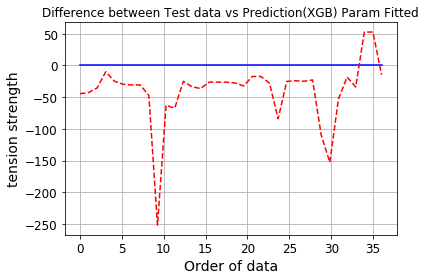

In [314]:
# Difference of train data
difference = ts_test_sort - ts_xgb_test_predictions_sort

xx = np.linspace(0,len(difference),len(difference))
y = np.zeros((len(difference),1))
#y.reshape(1,len(difference))
plt.figure
plt.grid()
plt.plot(xx,y,"b-", xx, difference,"r--")
plt.title("Difference between Test data vs Prediction(XGB) Param Fitted")
#plt.ylim(-30, 30)
plt.xlabel("Order of data")
plt.ylabel("tension strength")

save_fig("Difference_between_Test_data_vs_Prediction_XGB_ParamFitted")


## Extracting files

In [54]:
!ls images/BestHyperParameter/XGB_Regression/yield_stress_6V/


Difference_between_Test_data_vs_Prediction_6V_XGB_ParamFitted.png
Difference_between_Train_data_vs_Prediction_6V_XGB_ParamFitted.png
TestPrediction_with_6V_XGB_ParamFitted.png
TrainPrediction_with_6V_XGB_ParamFitted.png


In [0]:
from google.colab import files
# Upload local files to Colab VM
#uploaded = files.upload()
# Download Colab VM fiels to local
files.download('images/BestHyperParameter/XGB_Regression/yield_stress_6V/TrainPrediction_with_6V_XGB_ParamFitted.png')


In [0]:
files.download('images/BestHyperParameter/XGB_Regression/yield_stress_6V/TestPrediction_with_6V_XGB_ParamFitted.png')

In [0]:
files.download('images/BestHyperParameter/XGB_Regression/yield_stress_6V/Difference_between_Train_data_vs_Prediction_6V_XGB_ParamFitted.png')

In [0]:
files.download('images/BestHyperParameter/XGB_Regression/yield_stress_6V/Difference_between_Test_data_vs_Prediction_6V_XGB_ParamFitted.png')

In [0]:
files.download('/content/gdrive/My Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt')

In [0]:
`

## elongation

> class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, objective='reg:squarederror', booster='gbtree', tree_method='auto', n_jobs=1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, missing=None, num_parallel_tree=1, importance_type='gain', **kwargs)

In [13]:
# XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train_std, el_train_std)
el_predictions_xgb= xgb_reg.predict(X_train_std) * np.std(el_train) + np.mean(el_train)
xgb_mse = mean_squared_error(el_train, el_predictions_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse


[15:25:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.11547632384465144

Hyper Parameters Tuning: GridSearch CV function
---

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [315]:
range_1 = [-10, -5, -1, 1, 5, 10]
for i in range(len(range_1)):
    range_1[i] = 10 ** range_1[i]
    
print(range_1)

[1e-10, 1e-05, 0.1, 10, 100000, 10000000000]


In [316]:
range_2 = [-10, -7,-5, -3, -1, 0]
for i in range(len(range_2)):
    range_2[i] = 10 ** range_2[i]
    
print(range_2)

[1e-10, 1e-07, 1e-05, 0.001, 0.1, 1]


In [317]:
range_3 = [0, 1, 3, 5]
for i in range(len(range_3)):
    range_3[i] = 10 ** range_3[i]
    
print(range_3)

[1, 10, 1000, 100000]


In [14]:
range_1 =  [1e-22]

In [15]:
range_2 = [1e-20]

In [16]:
range_3 = [2]

In [476]:
range_4 = [0.3,0.5,0.7]

In [477]:
range_5=[0.2,0.4,0.6,0.8,1]

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = [
# tree-base model    
 {'booster': ['gbtree'], 'lambda': range_1, 'eta': range_2, 'gamma': range_1 , 
  'min_child_weight': range_1, 'alpha': range_1, 'max_depth': range_3, 'objective': ['reg:squarederror'],
  #'subsample': range_4, 'colsample_bytree': range_5
 }

]
    
xgb_reg = xgb.XGBRegressor()

grid_search = GridSearchCV(xgb_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_std, el_train_std)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [1e-22], 'booster': ['gbtree'],
                          'eta': [1e-20], 'gamma': [1e-22], 'lambda': [1e-22],
                          'max_depth

In [18]:
grid_search.best_estimator_

XGBRegressor(alpha=1e-22, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=1e-20, gamma=1e-22,
             importance_type='gain', lambda=1e-22, learning_rate=0.1,
             max_delta_step=0, max_depth=2, min_child_weight=1e-22,
             missing=None, n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [19]:
grid_search.best_params_

{'alpha': 1e-22,
 'booster': 'gbtree',
 'eta': 1e-20,
 'gamma': 1e-22,
 'lambda': 1e-22,
 'max_depth': 2,
 'min_child_weight': 1e-22,
 'objective': 'reg:squarederror'}

In [20]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.5035732618831474 {'alpha': 1e-22, 'booster': 'gbtree', 'eta': 1e-20, 'gamma': 1e-22, 'lambda': 1e-22, 'max_depth': 2, 'min_child_weight': 1e-22, 'objective': 'reg:squarederror'}


In [21]:
el_xgb_final_model =  grid_search.best_estimator_

In [22]:
el_xgb_train_predictions = el_xgb_final_model.predict(X_train_std) * np.std(el_train) + np.mean(el_train)
el_xgb_train_mse = mean_squared_error(el_train, el_xgb_train_predictions)
el_xgb_train_rmse = np.sqrt(el_xgb_train_mse)
el_xgb_train_rmse

0.20716800636580346

In [23]:
el_train_sum = np.zeros(1)

for i in range(1, len(el_train)):
    el_train_sum +=  el_train[i]
    
el_train_avg = el_train_sum / len(el_train)
el_xgb_train_err = el_xgb_train_rmse / el_train_avg * 100
print("el_xgb_train_err: ", el_xgb_train_err, '%')

el_xgb_train_err:  [12.75358598] %


In [24]:
el_xgb_test_predictions = el_xgb_final_model.predict(X_test_std) * np.std(el_test) + np.mean(el_test)
el_xgb_test_mse = mean_squared_error(el_test,el_xgb_test_predictions)
el_xgb_test_rmse = np.sqrt(el_xgb_test_mse)
el_xgb_test_rmse

0.3476328620739586

In [25]:
el_test_sum = np.zeros(1)

for i in range(1, len(el_test)):
    el_test_sum +=  el_test[i]
    
el_test_avg = el_test_sum / len(el_test)
el_xgb_test_err = el_xgb_test_rmse / el_test_avg * 100
print("el_xgb_test_err: ", el_xgb_test_err, '%')

el_xgb_test_err:  [20.89279305] %


### Feature importances

In [452]:
feature_importances = el_xgb_final_model.feature_importances_
feature_importances.shape

(4,)

In [487]:
print("Feature importances")
print("layer_height", feature_importances[0])
print("infill_density", feature_importances[1])
print("wall-_thickness", feature_importances[2])
print("nozzle_temperature", feature_importances[3])


Feature importances
layer_height 0.31074816
infill_density 0.13892731
wall-_thickness 0.14847589
nozzle_temperature 0.40184864


## Central Limit Theorem

In [371]:
print(cvres['mean_train_score'].shape)
print('Combinations')

(9,)
Combinations


In [372]:
mean_train_score = cvres['mean_train_score']
print(mean_train_score)

[-0.07827388 -0.04770746 -0.0339404  -0.02939518 -0.02589092 -0.02351809
 -0.02544663 -0.02537704 -0.03018177]


In [373]:
mean_test_score = cvres['mean_test_score']
print(mean_test_score)

[-0.24743091 -0.22167849 -0.21461997 -0.17889419 -0.18588576 -0.21843891
 -0.23243802 -0.22673933 -0.21263254]


In [374]:
std_train_score = cvres['std_train_score']
print(std_train_score)

[0.00697956 0.01069744 0.00985674 0.00986034 0.00952568 0.01120663
 0.01295644 0.01211844 0.01512416]


In [375]:
std_test_score = cvres['std_test_score']
print(std_test_score)

[0.07776607 0.05074068 0.05212535 0.06991597 0.05889923 0.09362901
 0.0793289  0.08294794 0.06294379]


In [376]:
!ls /content/gdrive/My\ Drive/validation

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [377]:
with open('/content/gdrive/My Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt', 'w') as f:
  for key in cvres.keys():
    f.write("\n")
    f.write(key)
    f.write(": ")
    f.write(np.str(cvres[key]))
    f.write("\n")


!cat /content/gdrive/My\ Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/validation/cvscores/XGB/yield_stress/XGB_6V.txt'

Train data plotting
---

In [33]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "BestHyperParameter/XGD_Regression/elongation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

Saving figure TrainPrediction_with_XGB_ParamFitted


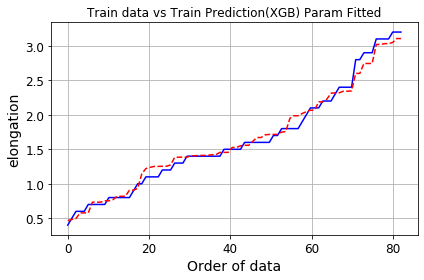

In [379]:
# Difference of train data
xx = np.linspace(0,len(X_train),len(X_train))
plt.figure
plt.grid()
el_train_sort = np.sort(el_train, axis=None)
el_xgb_train_predictions_sort= np.sort(el_xgb_train_predictions, axis=None)
plt.plot(xx,el_train_sort,"b-", xx, el_xgb_train_predictions_sort,"r--")
plt.title("Train data vs Train Prediction(XGB) Param Fitted")
plt.xlabel("Order of data")
plt.ylabel("elongation")
save_fig("TrainPrediction_with_XGB_ParamFitted")

Saving figure Difference_between_Train_data_vs_Prediction_XGB_ParamFitted


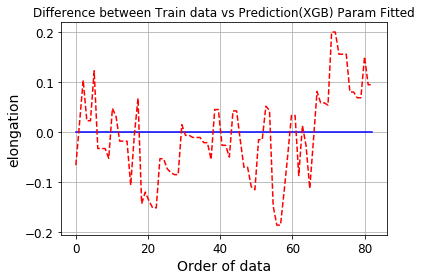

In [380]:
# Difference of train data
difference = el_train_sort - el_xgb_train_predictions_sort

xx = np.linspace(0,len(difference),len(difference))
y = np.zeros((len(difference),1))
#y.reshape(1,len(difference))
plt.figure
plt.grid()
plt.plot(xx,y,"b-", xx, difference,"r--")
plt.title("Difference between Train data vs Prediction(XGB) Param Fitted")
#plt.ylim(-30, 30)
plt.xlabel("Order of data")
plt.ylabel("elongation")

save_fig("Difference_between_Train_data_vs_Prediction_XGB_ParamFitted")


Test data plotting
---

Saving figure TestPrediction_with_XGB_ParamFitted


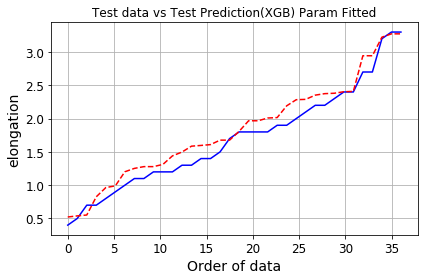

In [381]:
# Difference of train data
xx = np.linspace(0,len(X_test),len(X_test))
plt.figure
plt.grid()
el_test_sort = np.sort(el_test, axis=None)
el_xgb_test_predictions_sort= np.sort(el_xgb_test_predictions, axis=None)
plt.plot(xx,el_test_sort,"b-", xx, el_xgb_test_predictions_sort,"r--")
plt.title("Test data vs Test Prediction(XGB) Param Fitted")
plt.xlabel("Order of data")
plt.ylabel("elongation")
save_fig("TestPrediction_with_XGB_ParamFitted")

Saving figure Difference_between_Test_data_vs_Prediction_XGB_ParamFitted


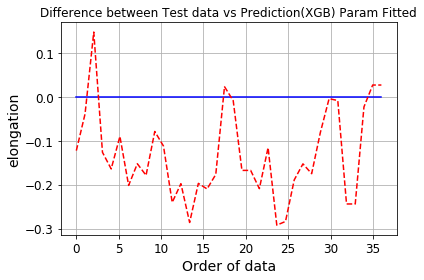

In [382]:
# Difference of train data
difference = el_test_sort - el_xgb_test_predictions_sort

xx = np.linspace(0,len(difference),len(difference))
y = np.zeros((len(difference),1))
#y.reshape(1,len(difference))
plt.figure
plt.grid()
plt.plot(xx,y,"b-", xx, difference,"r--")
plt.title("Difference between Test data vs Prediction(XGB) Param Fitted")
#plt.ylim(-30, 30)
plt.xlabel("Order of data")
plt.ylabel("elongation")

save_fig("Difference_between_Test_data_vs_Prediction_XGB_ParamFitted")


## Model Comparison

In [4]:
sgd_ts = 29.033
sgd_el =28.812

svm_ts = 13.997
svm_el = 15.535

mlp_ts = 29.368
mlp_el = 29.084

rf_ts = 4.836
rf_el = 9.974

gb_ts = 7.82
gb_el =15.192

xgb_ts = 3.356
xgb_el =15.945

ts_result = [sgd_ts, svm_ts, mlp_ts, rf_ts, gb_ts, xgb_ts]
el_result = [sgd_el, svm_el, mlp_el, rf_el, gb_el, xgb_el]
results = [sgd_ts,sgd_el, svm_ts, svm_el, mlp_ts, mlp_el, rf_ts, rf_el, gb_ts, gb_el, xgb_ts,xgb_el]

Saving figure Comparison between Models


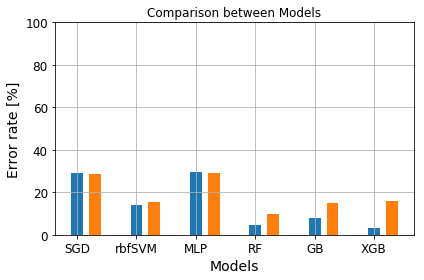

In [7]:
x = ['SGD', 'rbfSVM', 'MLP', 'RF', 'GB', 'XGB']

W_ = 0.3

plt.figure
plt.bar(x,ts_result, width=0.2)# x, el_result,'g')
plt.bar([i+W_ for i in range(len(el_result))],el_result, width=0.2)
plt.grid()
plt.ylim(0,100)
plt.xlabel('Models')
plt.ylabel('Error rate [%]')
plt.title('Comparison between Models')


save_fig('Comparison between Models')

In [0]:
()